# This notebook contains:
* Hovmöller plots of the BARRA-2 variables created in the BA_variable-to-netcdf notebook: surface winds, surface temp, winds at 100m, winds at 850hPA(to be cont'd)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import dask
from scipy.stats import circmean

In [2]:
# open netcdf files created in BA_variable-to-netcdf notebook
# mean over radar domain
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")
# values over study domain longitude
barra_towns_sfc = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns_sfc = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis_sfc = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc_winds_willis.nc", engine="h5netcdf",chunks="auto")

0.3.0


In [3]:
# values over study domain longitude
barra_towns_sfc_temp = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc_temp_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns_sfc_temp = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc_temp_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis_sfc_temp = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc_temp_willis.nc", engine="h5netcdf",chunks="auto")

In [6]:
def calc_mean_wdir(ds):
    radian = np.deg2rad(ds)
    circmean_ds = circmean(radian,high=(2*np.pi),low=0,nan_policy='omit')
    wdir_mean = np.rad2deg(circmean_ds)
    return wdir_mean
print('Mean BARRA2 surface cairns wind direction: ',calc_mean_wdir(barra_cairns_sfc.wind_dir))

Mean BARRA2 surface cairns wind direction:  100.42739959333734


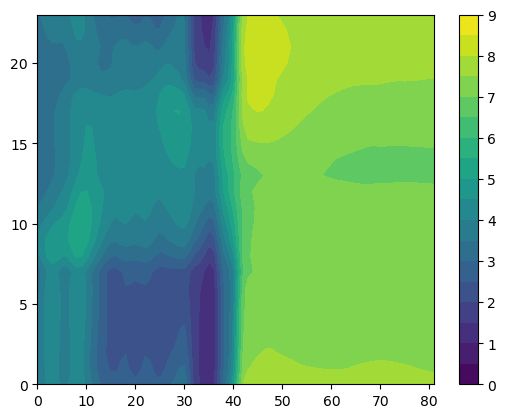

In [5]:
speed = barra_cairns_sfc.wind_speed.groupby(barra_cairns_sfc.time.dt.hour).mean(dim="time")
speed_roll = np.roll(speed,shift=10,axis=0)
cf = plt.contourf(np.arange(0,82,1),np.arange(0,24,1),speed_roll,levels=np.arange(0,9.5,0.5))
plt.colorbar(cf)
# plt.quiver(np.arange(0,82,1),np.arange(0,24,1), speed_roll * np.cos(np.radians(dir_roll)),
#            speed_roll * np.sin(np.radians(dir_roll)),
#            angles='xy', scale_units='xy', scale=5, color='black', width=0.005)


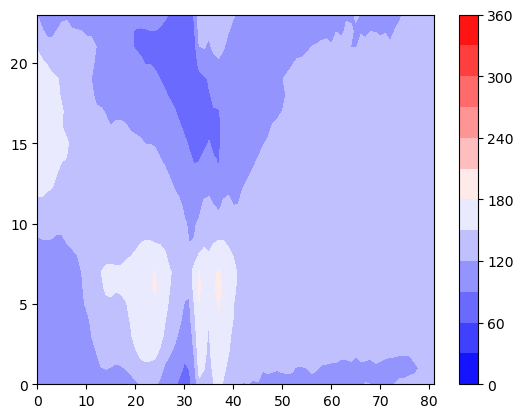

In [73]:
dir = barra_cairns_sfc.wind_dir.groupby(barra_cairns_sfc.time.dt.hour).mean(dim="time")
dir_roll = np.roll(dir,shift=10,axis=0)
cf = plt.contourf(np.arange(0,82,1),np.arange(0,24,1),dir_roll,levels=np.arange(0,390,30),cmap="bwr")
plt.colorbar(cf)

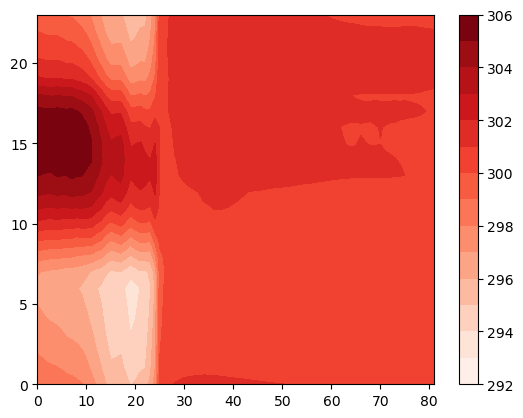

In [96]:
temp = barra_cairns_sfc_temp.tas.groupby(barra_cairns_sfc_temp.time.dt.hour).mean(dim="time")
temp_roll = np.roll(temp,shift=10,axis=0)
cf = plt.contourf(np.arange(0,82,1),np.arange(0,24,1),temp_roll,levels=np.arange(292,307,1),cmap="Reds")
plt.colorbar(cf)